# PRÁTICA GUIADA: Explorando dígitos escritos à mão

Para demonstrar esses princípios em um problema mais interessante, vamos considerar uma parte do antigo problema de reconhecimento óptico de caracteres (OCR, optical character recognition): a identificação de dígitos escritos à mão. 

Em aplicações reais, esse problema inclui tanto localizar quanto identificar caracteres em uma imagem. Aqui, vamos pegar um atalho: usaremos um conjunto de dados de dígitos pré-formatados incluídos em Scikit-Learn, evitando trabalhos adicionais que não são relevantes no momento. 

### Carregar e visualizar os dados de dígitos

Usar a interface de acesso aos dados de Scikit-Learn e observá-los:

In [1]:
%matplotlib inline

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.images.shape

(1797, 8, 8)

Os dados da imagem são armazenados como um array tridimensional: 1797 amostras, cada uma composta por uma grade de 8 x 8 pixels (cada um com tons de cinza).

Vamos visualizar os primeiros cem dígitos:

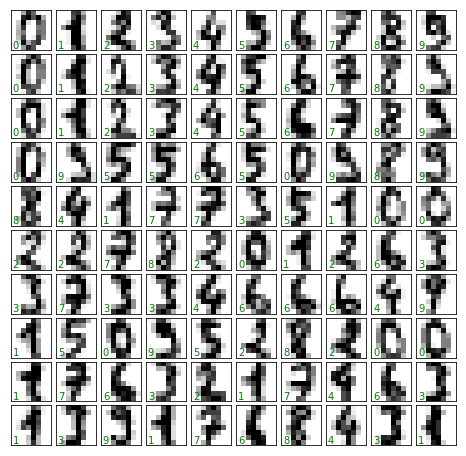

In [3]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(10, 10, figsize=(8, 8),
subplot_kw={'xticks':[], 'yticks':[]},gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(digits.target[i]),
transform=ax.transAxes, color='green')

Para trabalhar com esses dados no Scikit-learn, precisamos de uma representação bidimensional de tamanho ``[n_samples, n_features]``. 
Podemos conseguir essa transformação tratando cada pixel da imagem como um recurso diferente: isto é, esticando cada imagem matriz para obter um array unidimensional com 64 pixels de comprimento representando cada dígito. 

Além disso, precisamos do vetor target, que fornece a tag determinada anteriormente para ada dígito. 
Estas duas quantidades estão incluídas no conjunto de dados de teste, sob os atributos ``data`` e ``target``, respectivamente:

In [4]:
X = digits.data
X.shape

(1797, 64)

In [5]:
y = digits.target
y.shape

(1797,)

Aqui, vemos que há 1.797 amostras e 64 recursos.

### Aprendizagem não supervisionada: Redução da dimensionalidade 

Gostaríamos de visualizar nossos pontos no espaço de parâmetros de 64 dimensões, mas é muito difícil visualizar efetivamente os pontos em um espaço de tão alta dimensionalidade. 
Em vez disso, vamos reduzir a dimensão para 2, usando um método não supervisionado. 
Aqui, usaremos o algoritmo chamado *Isomap* (do conjunto de algoritmos conhecido como manifold learning) e transformaremos os dados em duas dimensões:

In [6]:
from sklearn.manifold import Isomap
iso = Isomap(n_components=2)
iso.fit(digits.data)
data_projected = iso.transform(digits.data)
data_projected.shape

(1797, 2)

Podemos ver que agora os dados projetados são bidimensionais.

Vamos plotar esses dados para ver se podemos aprender algo com sua estrutura:

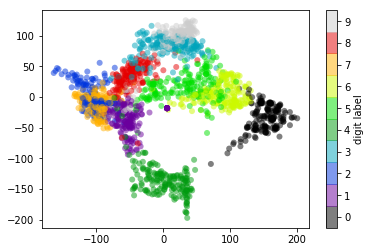

In [7]:
plt.scatter(data_projected[:, 0], data_projected[:, 1], c=digits.target,
edgecolor='none', alpha=0.5,cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar(label='digit label', ticks=range(10))
plt.clim(-0.5, 9.5);

Este enredo nos dá alguma intuição sobre o quão bem diversos números estão separados no espaço de parâmetro de 64 dimensões. 

Por exemplo, os zeros (em preto) e os uns (em roxo) têm muito pouca sobreposição no espaço de parâmetros. 

Intuitivamente, isso faz sentido: um 0 está vazio no centro da imagem, enquanto um 1 normalmente terá pixels escuros no centro. 

Por outro lado, parece haver um espectro mais ou menos contínuo entre 1s e 4s: podemos entender isso observando que algumas pessoas desenham 1s com "chapéus pequenos", o que faz com que pareçam 4s.  

No entanto, geralmente, os diferentes grupos parecem estar relativamente bem separados no espaço de parâmetros: isso nos diz que até mesmo um algoritmo de classificação muito simples poderia ser executado corretamente sobre esses dados.
Vamos tentar:

### Classificação de dígitos

Vamos aplicar um algoritmo de classificação ao conjunto de dados de dígitos. 

Como fizemos anteriormente com Iris, vamos separar os dados em conjuntos de treinamento e teste e ajustar um modelo do tipo Naive Bayes Gausiano:

In [8]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)

In [9]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(Xtrain, ytrain)
y_model = model.predict(Xtest)

Agora que fizemos a previsão, podemos validar sua precisão comparando os valores corretos do conjunto de teste com as previsões.

In [10]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, y_model)

0.8333333333333334

Inclusive, com este modelo extremamente simples, conseguimos mais de 80% de precisão na classificação de dígitos! 

No entanto, esta única métrica não nos diz *onde* cometemos erros. Uma maneira de visualizar isso é usar a *matriz de confusão*, que podemos calcular com Scikit-Learn e plotar com o Seaborn:

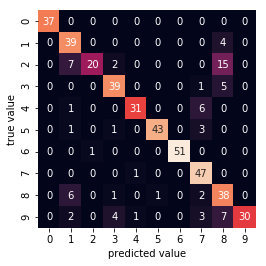

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(ytest, y_model)

sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value');

Isso nos mostra onde costumam estar os pontos com tags incorretas: por exemplo, um grande número de 2 é classificado erroneamente como 1s ou como 8s. 

Outra maneira de obter intuição sobre as características do modelo é plotar os dígitos de entrada novamente, mas desta vez com as tags previstas. 

Usaremos a cor verde para as tags corretas e vermelha paras as incorretas:

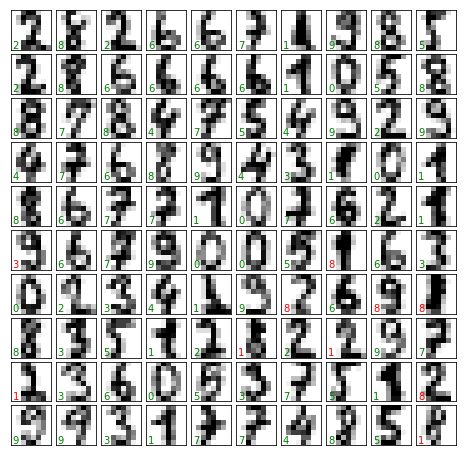

In [12]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
subplot_kw={'xticks':[], 'yticks':[]},gridspec_kw=dict(hspace=0.1, wspace=0.1))
test_images = Xtest.reshape(-1, 8, 8)

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(y_model[i]),
transform=ax.transAxes,color='green' if (ytest[i] == y_model[i]) else 'red')

Examinando este subconjunto dos dados, podemos ter um insight sobre onde o desempenho do algoritmo pode não estar sendo ideal. 
Para ir além da nossa taxa de proporção de 80%, poderíamos passar para um algoritmo mais sofisticado, como Support Vector Machines, florestas aleatórias ou outras técnicas de classificação.